### Подготовительный этап.

In [27]:
!apt install libspatialindex-dev
!pip install osmnx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [0]:
import osmnx as ox
import networkx as nx
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import csv
import json # пока писать будет в json, но если что переделаем

Выгрузим граф Уфы с помощью библиотеки osmnx

In [0]:
place = {'city' : 'Ufa',
         'country' : 'Russia'}
G = ox.graph_from_place(place, network_type='drive', simplify=False)

# fig, ax = ox.plot_graph(G, dpi=500, node_color='#000000', node_size=2, edge_color='#999999', edge_linewidth=0.2)

In [0]:
# создадим список всех точек графа
nodes_list = list(G.nodes()) 

In [0]:
# пишем узлы в csv
nodes_df = pd.DataFrame(nodes_list)
nodes_df.to_csv('nodes.csv', index=False)

По-хорошему, тут нужно создать матрицу и лист смежности


In [0]:
# нахождение расстояний между смежными узлами 
a = G.adj
dictionary = {}
i = 0
for key, value in a.items():
    if i == 10:
        break
    for key_a, value_a in value.items():

        if key not in dictionary:
            dictionary[key] = [{key_a:value_a[0]['length']}]
        else:
            dictionary[key].append({key_a:value_a[0]['length']})                  

In [0]:
# пишем список смежности в csv
adj_list = nx.generate_adjlist(G, delimiter=' ')
with open('adjacency_list.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=' ')
    for line in adj_list:
        writer.writerow(line)

In [0]:
# матрица смежностти в пандас
G_pd = nx.to_pandas_adjacency(G)

# можно записать в эксель и это даже работает!!
G_pd.to_csv('matrix_adjacency_pandas.csv')

In [0]:
# переводив в нампаевский ndarray
# !запускать только один раз!
G_pd = G_pd.values

In [0]:
print(G_pd)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
# пишем полученный ndarray в csv
with open('matrix_adjacency.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in G_pd:
        writer.writerow(line)

Штука внизу не работает, потому что мы дикты создаем только ниже (Оксана)


---

Соре не использовала ее, можно потом пониже поместить

In [0]:
# вместо нулей и единиц записываем в матрицу смежности расстояния между нодами (по формуле из файла)
for i in range(len(G_pd)):
    for j in range(len(G_pd)):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]   
            weight = 1
            if nodes_list[i] in hospitals_dict.values():
                weight = random() + 1
            G_pd[i][j] = distance * weight
# если ребра между нодами нет, то заполняем большими расстояниями (для нахождения крастчайших путей)
# возможно, можно придумать что-то менее костыльное
        if G_pd[i][j] == 0:
            G_pd[i][j] = 10**10

Выбираем M больниц и N домов

In [0]:
# вытаскиваем все больницы и дома
buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)

hospitals = []
apartments = []
build = buildings['building'].to_dict()

for key,value in build.items():
    if value == 'hospital':
        hospitals.append(key)
    elif value == 'apartments':
        apartments.append(key)


In [0]:
# для каждой больницы и дома находим соответсвующие им (ближайшие) ноды на графе
a = buildings.to_dict()
hospitals_dict = {}
apartments_dict = {}

for i in hospitals:   
    bounds = a['geometry'][i].bounds
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    hospitals_dict[i] = nearest_node

for i in apartments:
    bounds = a['geometry'][i].bounds    
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node

In [0]:
# оставим только уникальные значения G
temp = hospitals_dict.copy()
hospitals_dict = {}

for key, value in temp.items():
  if value not in hospitals_dict.values():
    hospitals_dict[key] = value

temp = apartments_dict.copy()
apartments_dict = {}

for key, value in temp.items():
  if (value not in apartments_dict.values()) and (value not in hospitals_dict.values()):
    apartments_dict[key] = value

In [0]:
M = 10
N = 100

hospitals_dict = dict(random.sample(list(hospitals_dict.items()), M))
apartments_dict = dict(random.sample(list(apartments_dict.items()), N))

Создадим несколько структур данных для работы впоследствии

In [0]:
# Создаем словарь {id узла}: {его index в списке узлов} 
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i]=index 

In [0]:
# делаем листы для использования Дейсктры 
hospital_values = list(hospitals_dict.values())
apartments_values = list(apartments_dict.values())

In [0]:
# создаем общий лист, чтобы сделать и дома, и больницы одновременно
new_nodes = apartments_values + hospital_values
new_nodes = np.array(new_nodes)

In [0]:
'''
nodes_list - лист со всеми точками графа G
nodes_numbers - {id узла}: {его index в списке узлов}

hospitals_dict, apartments_dict - словари, ключ - точка из footsprint, значение - точка G
hospital_values = list(hospitals_dict.values())
apartments_values = list(apartments_dict.values())
new_nodes = apartments_values + hospital_values

'''

### Дейкстра, использующая кучу

In [0]:
from heapq import heappush, heappop

def dijkstra_heap (G, source):
    
    G_succ = G._succ 

    push = heappush
    pop = heappop
    weight = lambda d: min(attr.get(weight, 1) for attr in d.values()) #понятия не имею что происходит в этой строчке увы

    seen = {}  # минимальное расстояние до ключа-точки  
    dist = {}
    path = {}
    # fringe is heapq with 2-tuples (distance,node)
    fringe = []

    seen[source] = 0
    push(fringe, (0, source, None))

    while fringe:

        (d, v, pred) = pop(fringe)

        if v in dist:
            continue  # already searched this node.

        dist[v] = d
      
        if pred != None:

          if len(path[pred]) > 0:
            path[v] = (path[pred]).copy()
            path[v].append(v)      
          else:
            path[v] = [pred, v]
        else:
          path[source] = []

        for u, e in G_succ[v].items():
            cost = weight(e) #e - ребро (мультиграф же,значит их несколько, выбираем наименьший вес)

            if cost is None: # видимо если ребра нет, возможно стоит заменить на бесконечное значение
                continue

            vu_dist = dist[v] + cost
             
            if u not in seen or vu_dist < seen[u]: #если мы еще не искали путь до u или новое расстояние меньше найденного              
                seen[u] = vu_dist
                push(fringe, (vu_dist, u, v))
    return path, dist

Запуск Дейкстры



In [0]:
  paths = {}
  dists = {}

  import time

  start = time.time()

  for i in range(len(new_nodes)):
      paths[new_nodes[i]], dists[new_nodes[i]], = dijkstra_heap(G, new_nodes[i])

  print(time.time() - start)

34.38050818443298


Это дерево еще понадобится, так что я бы его куда-нибудь тоже скачала (хотя оно большое) (Милена)

---
Я вроде записала (Оксана)
У меня оно съедает всю RAM
постарюсь что-то придумать другое


---
Вроде переписала под новый формат, он должен поменьше весить, но не запускала пока. (Милена)


In [0]:
with open('paths.csv', 'w') as f:
    for key in paths.keys():
        f.write("%s,%s\n"%(key, paths[key]))

KeyboardInterrupt: ignored

Уменьшаем дерево до точек N+M

In [0]:
  # сокращаем лист путей до точек из списка

  def reduce_paths (paths, new_nodes):

    small_paths = paths.copy()

    for key, node_paths in paths.items():

      if key not in new_nodes:
        del small_paths[key]
        continue

      keys = list(node_paths.keys())
      # типа пути от одной точки
      small_node_paths = node_paths.copy()

      for child in keys:
        if child not in new_nodes:
          del small_node_paths[child]

      keys = list(small_node_paths.keys())

      for child in keys:

        temp = small_node_paths[child].copy()
        
        for el in small_node_paths[child]:
          if el not in new_nodes:
            temp.remove(el)
        small_node_paths[child] = temp

      small_paths[key] = small_node_paths
    return small_paths

In [0]:
  start = time.time()
  small_paths = reduce_paths (paths, new_nodes)
  print(time.time() - start)

15.50744915008545


Матрица кратчайших путей для N+M точек

In [0]:
  # матрица в которой будем хранить значения кратчайших путей
  short_path_matrix = np.zeros((len(new_nodes), len(new_nodes)))
  
  for i in range(N+M):  
    dist = dists[new_nodes[i]]
    for j in range(N+M): 
      if new_nodes[j] in small_paths[new_nodes[i]]:
        short_path_matrix[i][j] = dist[new_nodes[j]]
      else: 
        short_path_matrix[i][j] = 0  

In [0]:
del dist
 # короче если периодически таким образом удалять переменные, то можно чистить ram, если будет очень нужно

In [0]:
 short_path_matrix

array([[  0.,  83., 302., ..., 183.,  49.,  52.],
       [ 82.,   0., 266., ..., 137.,  39.,  42.],
       [329., 269.,   0., ..., 163., 281., 280.],
       ...,
       [193., 142., 165., ...,   0., 145., 144.],
       [ 49.,  39., 254., ..., 135.,   0.,  11.],
       [ 52.,  42., 253., ..., 134.,  11.,   0.]])

In [0]:
# записываем матрицу кратчайших путей в csv
with open('matrix_dijkstra.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in short_path_matrix:
        writer.writerow(line)

In [0]:
# ставим вместо 0 - 10**10
for i in range(len(new_nodes)):
    for j in range(len(new_nodes)):
        if short_path_matrix[i][j] == 0:
            short_path_matrix[i][j] = 10**10

Создадим лист смежности дерева для более удобного взаимодействия

In [0]:
small_tree_dict_adj = {}

# беру пути до каждой точки и строю из них дерево в формате вершина: (ребенок, длина ребра)
for root, node_paths in small_paths.items():

  seen = {}
  new_tree = {}

  for node in node_paths:
    new_tree[node] = []

  for node in node_paths:

    if node in seen:
      continue

    seen[node] = 1

    path = node_paths[node]

    for i in range(1,len(path)):
      if path[i] in seen:
        continue
      seen[path[i]] = 1
      new_tree[path[i-1]].append((path[i], dists[root][path[i-1]] - dists[root][path[i]]))

    if(len(path) > 0):
      new_tree[path[len(path) - 2]].append((node, dists[root][node] - dists[root][path[len(path) - 2]]))

    small_tree_dict_adj[root] = new_tree

In [0]:
# пишем в csv лист смежности дерева
with open('small_tree_adj_list.csv', 'w') as f:
    for key in small_tree_dict_adj.keys():
        f.write("%s,%s\n"%(key, small_tree_dict_adj[key]))

Матрицы смежности для разных узлов

In [0]:
# сделать матрицу смежности из получившихся деревьев
def make_adj_m (tree, nodes):
  adjancecy_m = np.zeros((110, 110))
  for node in nodes:
    for child, dlina in tree[node]:
      adjancecy_m[np.where(nodes == node)[0][0]][np.where(nodes == child)[0][0]] = dlina
  return adjancecy_m

In [0]:
# можно сделать и скачать все матрицы смежности

adjancecy_m_dict = {}

for node in new_nodes:
  tree = small_tree_dict_adj[node]
  adjancecy_m = make_adj_m (tree, new_nodes)
  adjancecy_m_dict[node] = adjancecy_m.copy()
  adjancecy_m_pd = pd.DataFrame(data = adjancecy_m, index = new_nodes, columns = new_nodes)
  #adjancecy_m_pd.to_csv('adjancecy_m_'+str(new_nodes[100])) #не хочу качать сейчас


In [0]:
adjancecy_m_dict[new_nodes[0]]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Визуализация** дерева кратчайших путей для первой точки new_nodes

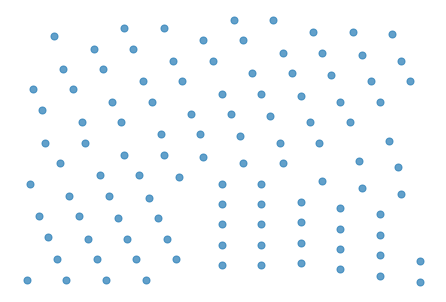

In [0]:
small_adjancecy = adjancecy_m_dict[new_nodes[0]]

new_G = nx.from_numpy_matrix(small_adjancecy, create_using = nx.DiGraph)

# рисую граф
from networkx.drawing.nx_pydot import graphviz_layout
pos = graphviz_layout(new_G, prog='twopi')
nx.draw(new_G, pos, node_size = 50, alpha = 0.7)

Нам нужен json?

---
Ну прост дерево выглядит нагляднее в json, чем в csv. Но если мы можем красиво записать в csv, то не нужен. **ЕЩЕ ВАЖНО** предлагаю как-нибудь скачать картинки деревьев в png/jpeg/etс, так удобнее будет показывать имхо (Оксана)

Согласна!


In [0]:
 #пишем в json файл дерево кратчайших путей
 with open('short_path_tree.json', 'w') as f:
     json.dump(tree_dict, f)

In [0]:
 with open('short_path_tree.json', 'r') as fr:
     head = [next(fr) for _ in range(20)]
     print(head)

In [0]:
# пишем в json все кратчайшие пути
with open('short_paths.json', 'w') as f:
    json.dump(short_paths, f)

А это?

---
Если в твоих функциях дальше нигде не используется, то не нужно (Оксана)


In [0]:
# получение ключа 
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
    return -1

# получение айди
def get_id(nodes_numbers, index_nodes, i):
    temp = get_key(nodes_numbers, index_nodes[i])
    if temp == -1:
        return "Не найдено id узла"
    else:
        return temp

Всякое разное (понадобится далее)

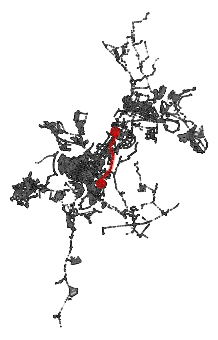

(<Figure size 468.322x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f08d1980cc0>)

In [0]:
# пример визуализации кратчайших путей (точки взяты из предыдущего пункта)
route = nx.shortest_path(G,
                         892683760,
                         498826321, 
                         weight='length') 

ox.plot_graph_route(G, route, dpi=500, node_color='#000000', node_size=2, edge_color='#999999', edge_linewidth=0.2)

Нижняя шляпа не работает, но я подумаю как ее поправить

### Первое задание.

In [0]:
#from numpy import genfromtxt
# считываем матрицу кратчайших расстояний из csv файла
# data = genfromtxt('/content/matrix_dijkstra.csv', delimiter=',') 

# можно загрузить эту матрицу если она есть в оперативке
data = short_path_matrix.copy()

In [0]:
#не нужно искать расстояние между жилыми домами

for i in range(M+N):
  if new_nodes[i] in apartments_values:
    for j in range(M+N):
      if new_nodes[j] in apartments_values:
        data[i][j] = 10**10

### Пункт 1.а 
Для каждого дома определить ближайший от узла объект (путь “туда”), ближайший к объекту узел (путь “обратно”), объект, расстояние до которого и обратно минимально (“туда и обратно”).

In [0]:
nearest_hosp_list = [[0 for i in range(3)] for j in range(N)]
temp = short_path_matrix.copy()


for i in range(N):
  node = apartments_values[i]
  index = np.where(new_nodes == node)
  # туда
  nearest_hosp_list[i][0] = new_nodes[np.reshape(temp[index][:], 110).argmin()]
  # обратно
  nearest_hosp_list[i][1] = new_nodes[np.reshape(temp[:][index], 110).argmin()]
  #туда и обратно
  nearest_hosp_list[i][2] = new_nodes[(np.reshape(temp[index][:], 110) + 
                              np.reshape(temp[:][index], 110)).argmin()]
                              

In [0]:
nearest_hosp_list

In [0]:
route = paths[apartments_values[0]][nearest_hosp_list[0][0]].copy()

In [0]:
route.append(nearest_hosp_list[0][0])

In [0]:
route

[1156170689,
 2244018298,
 1156170669,
 2656249800,
 2656245388,
 1082551625,
 2656245027,
 2656245036,
 2409462143,
 3237539416,
 2900144373,
 3237539406,
 1082551676,
 3237539428,
 2900144370]

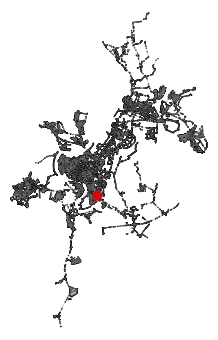

(<Figure size 468.322x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f509fb11e48>)

In [0]:
# пример визуализации кратчайших путей (точки взяты из предыдущего пункта)
ox.plot_graph_route(G, route, dpi=500, node_color='#000000', node_size=2, edge_color='#999999', edge_linewidth=0.2)

In [0]:
some_tree = small_paths[new_nodes[0]]
routes = []
for el in new_nodes:
  if el == new_nodes[0]:
    continue
  route = paths[new_nodes[0]][el]
  routes.append(route )

In [0]:
len(routes)

109

In [0]:
ox.plot_graph_routes(G, routes, save=True, close=True, file_format='png', filename='short_path_tree', dpi=500, fig_height = 30, fig_width = 30, node_color='#000000', node_size = 1, orig_dest_node_size=5, edge_color='#999999', edge_linewidth=0.7)

### Пункт 1.b
Для каждого дома определить объекты, расположенные не далее, чем в X км для каждого из трех вариантов “туда”, “обратно”, “туда и обратно”.

In [0]:
# возвращаемый список содержит списки с 3-мя списками индексов подходящих объектов: "туда", "обратно" и "туда и обратно" 
# содержат своё количество индексов - это списки второго уровня,индекс списка первого уровня соответствует индексу дома во входной матрице расстояний. 
def find_in_radius(short_path_matrix, radius, apartments_values, new_nodes):

    permissible_hosps = [[[] for i in range(3)] for j in range(len(apartments_values))]

    for node in apartments_values:
        index = np.where(new_nodes == node)[0][0]
        for j in range(len(new_nodes)):
            if short_path_matrix[index][j] <= radius:
                permissible_hosps[index][0].append(new_nodes[j])
            if short_path_matrix[j][index] <= radius:
                permissible_hosps[index][1].append(new_nodes[j])
            if short_path_matrix[index][j] + short_path_matrix[j][index] <= radius:
                permissible_hosps[index][2].append(new_nodes[j])

    return permissible_hosps

In [0]:
# запуск программы, radius произвольный
radius = 100
hosps_in_radius = find_in_radius(data, radius, apartments_values, new_nodes)

In [0]:
i1 = np.where(new_nodes == apartments_values[0])[0][0]
i2 = np.where(new_nodes == hosps_in_radius[0][1][0])[0][0]
data[i1][i2] # < radius

49.0

In [0]:
hosps_in_radius

### Пункт 2
Определить, какой из объектов расположен так, что расстояние между ним и самым дальним домом минимально (“туда”, “обратно”, “туда и обратно”).

In [0]:
# возвращаемый список содержит три больницы - [ "туда", "обратно", "туда и обратно" ], где "туда" – из дома в больницу
def get_optimal_hospitals(short_path_matrix, hospital_values, apartments_values, new_nodes):

    optimal_hosps = []
    
    there = short_path_matrix.copy()
    back = short_path_matrix.copy()
    iter1 = 0
    iter2 = 0

    for i in range (len(new_nodes )):
      if new_nodes[i] not in hospital_values:
        #удаляем cтроку
        there = np.delete(there, iter1, 0)
        #удаляем столбец
        back = np.delete(back, iter1, 1))
        iter1 -= 1

      else:
        #удаляем cтолбец
        there = np.delete(there, iter2, 1)
        #удаляем строку
        back = np.delete(back, iter2, 0)

        iter2 -= 1

      iter1 += 1
      iter2 += 1

    # туда 
    # возьмем минимум от максимума по столбцам
    index = (np.amax(there, 1)).argmin()
    optimal_hosps.append(apartments_values[index])

    # обратно
    # возьмем минимум от максимума по строкам
    index = (np.amax(back, 0)).argmin()
    optimal_hosps.append(apartments_values[index])

    # туда и обратно
    index = (np.amax(there, 1) + np.amax(back, 0)).argmin()
    optimal_hosps.append(apartments_values[index])
    return optimal_hosps

In [0]:
# запуск программы
opt = get_optimal_hospitals(data, hospital_values, apartments_values, new_nodes)
print(opt)

In [0]:
routes = []
for el in apartments_values:
  index = np.where(new_nodes == el)[0][0]
  route = paths[opt[2]][new_nodes[index]]
  routes.append(route)

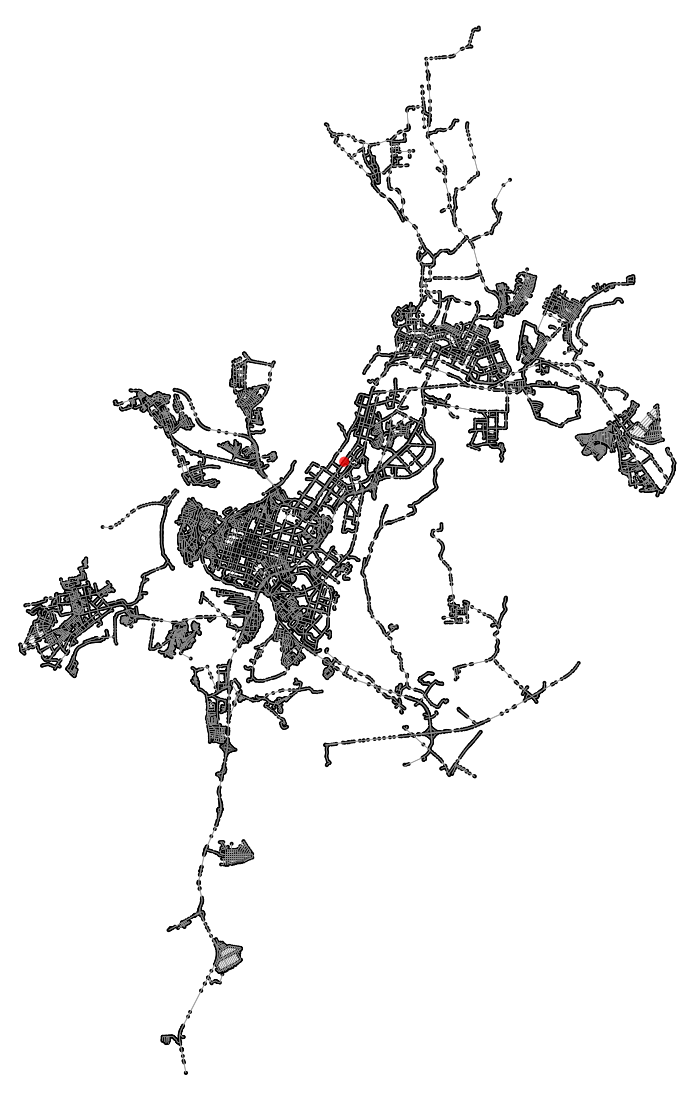

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f507b5e1048>)

In [0]:
# точка (у меня (Милены) она ожидаемо примерно в центре города)
ox.plot_graph_route(G, [opt[2]], dpi=500, node_color='#000000', node_size=2, edge_color='#999999', edge_linewidth=0.2)

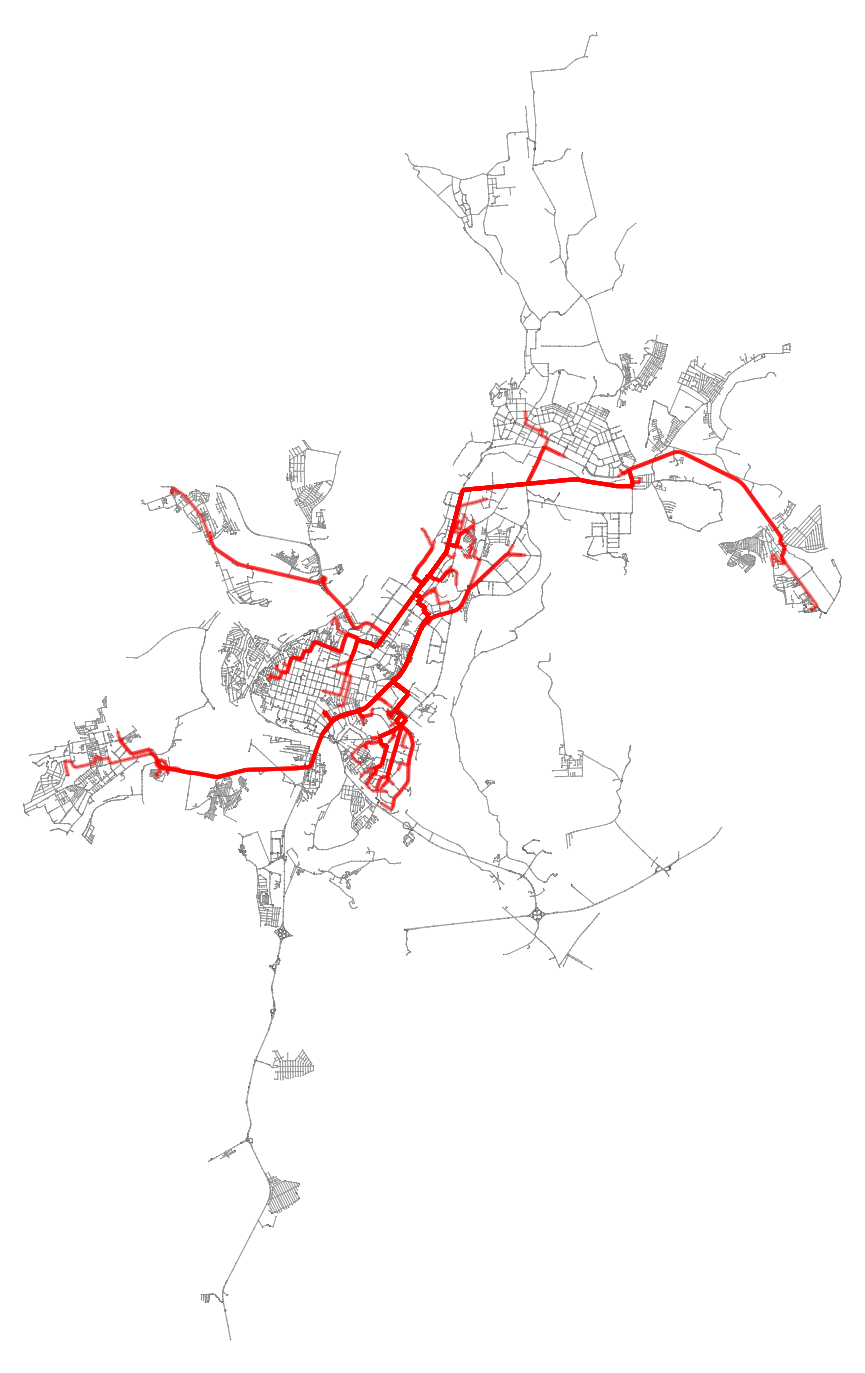

(<Figure size 1800x1800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f50bd9b1860>)

In [0]:
# дерево кратчайших путей от самой оптимальной больницы
'''
ox.plot_graph_routes(G, routes, save=True, close=True, file_format='png', 
                     filename='opt_hosp_short_path_tree', dpi=500, fig_height = 30, fig_width = 30, 
                     node_color='#000000', node_size = 1, orig_dest_node_size=5, edge_color='#999999', edge_linewidth=0.7)
'''
ox.plot_graph_routes(G, routes, dpi=500, fig_height = 25, fig_width = 25, 
                     node_color='#000000', node_size = 1, orig_dest_node_size=5, edge_color='#999999', edge_linewidth=0.7)

### Пункт 3

Определить, для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех домов минимальна.

In [0]:
def from_hosp_to_ap_min_sum (short_path_matrix, hospital_values, new_nodes):
    
    short_path_hosp_to_ap = short_path_matrix.copy()
    iter1 = 0
    iter2 = 0

    for i in range (len(new_nodes )):
      if new_nodes[i] not in hospital_values:
        #удаляем cтроку
        short_path_hosp_to_ap = np.delete(short_path_hosp_to_ap, iter1, 0)
        iter1 -= 1

      else:
        #удаляем cтолбец
        short_path_hosp_to_ap = np.delete(short_path_hosp_to_ap, iter2, 1)
        iter2 -= 1

      iter1 += 1
      iter2 += 1

    index = (np.sum(short_path_hosp_to_ap, 1)).argmin()
    return hospital_values[index]

In [0]:
# запуск программы
min_hosp_id = from_hosp_to_ap_min_sum(data, hospital_values, new_nodes)
print(min_hosp_id)

2661495390


### Пункт 4
Определить, для какого объекта инфраструктуры построенное дерево кратчайших путей имеет минимальный вес.

In [0]:
hosp_paths = {}
hosp_dists = {}

import time

start = time.time()

for i in range(len(hospital_values)):
    hosp_paths[hospital_values[i]], hosp_dists[hospital_values[i]], = dijkstra_heap(G, hospital_values[i])

print(time.time() - start)

7.33025336265564


In [0]:
  start = time.time()
  small_hosp_paths = reduce_paths (hosp_paths, new_nodes)
  print(time.time() - start)

1.6054790019989014


In [0]:
small_hosp_paths[hospital_values[0]]

In [0]:
min_value = 10**10
min_hospital_id = 0

for i in range(len(small_hosp_paths)):
  prom_dist =  
  if min_value > :
    min_value = 
    min_hospital_id = hospital_values[i]

print("Min tree:", min_value)
print("Hospital id:",  min_hospital_id)

TypeError: ignored

In [0]:
small_tree_dict_adj = {}

# беру пути до каждой точки и строю из них дерево в формате вершина: (ребенок, длина ребра)
for root, node_paths in small_paths.items():

  seen = {}
  new_tree = {}

  for node in node_paths:
    new_tree[node] = []

  for node in node_paths:

    if node in seen:
      continue

    seen[node] = 1

    path = node_paths[node]

    for i in range(1,len(path)):
      if path[i] in seen:
        continue
      seen[path[i]] = 1
      new_tree[path[i-1]].append((path[i], dists[root][path[i-1]] - dists[root][path[i]]))

    if(len(path) > 0):
      new_tree[path[len(path) - 1]].append((node, dists[root][node] - dists[root][path[len(path) - 1]]))

    small_tree_dict_adj[root] = new_tree

In [0]:
  # сокращаем лист путей до точек из списка

  def reduce_paths (small_paths, root_nodes, child_notes):

    small_paths = paths.copy()

    for key in root_nodes:
      
      node_paths = small_paths[key]

      if key not in new_nodes:
        del small_paths[key]
        continue

      keys = list(node_paths.keys())
      # типа пути от одной точки
      small_node_paths = node_paths.copy()

      for child in keys:
        if child not in new_nodes:
          del small_node_paths[child]

      keys = list(small_node_paths.keys())

      for child in keys:

        temp = small_node_paths[child].copy()
        iterr = 0
        for el in small_node_paths[child]:
          if iterr == 0:
            iterr +=1
            continue
          if el not in new_nodes:
            temp.remove(el)
        small_node_paths[child] = temp

      small_paths[key] = small_node_paths
    return small_paths

In [0]:
reduce_paths(small_paths, hospital_values, apartments_values)

### Второе задание.
На карте случайным образом выбраны N узлов (домов) и один из объектов инфраструктуры.

### Пункт 1
Построить дерево кратчайших путей от объекта до выбранных узлов. Вычислить общую длину дерева, а также сумму кратчайших расстояний от объекта до всех заданных узлов.

In [0]:
choosen_hospital = {}
# просто выбираем рандомную больницу из hospitals_dict (я выбрала третью)
choosen_hospital = {89665061: 7512139535}

In [0]:
tree_choosen = {}
index = 7512139535
tree_choosen = dijkstra_heap(G, index)

ТОЧНО ТАКЖЕ НУЖНО УБРАТЬ ЛИШНИЕ ВЕРШИНЫ

### Пункт 2
Разбить выбранные узлы на кластеры, используя метод полной связи (сomplete-linkage clustering). Построить дендрограмму разбиения узлов.

In [0]:
import scipy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette

In [0]:
path_matrix = np.empty([len(apartments_values), len(apartments_values)])
for i in range(len(apartments_values)):
  for j in range(len(apartments_values)):
    path_matrix[i][j] = nx.dijkstra_path_length(G, apartments_values[i], apartments_values[j])

In [138]:
path_matrix

array([[  0., 127.,  96., ..., 129., 130., 210.],
       [127.,   0., 167., ..., 198., 199., 288.],
       [ 96., 166.,   0., ...,  67.,  55., 161.],
       ...,
       [129., 199.,  65., ...,   0.,  71., 151.],
       [131., 201.,  55., ...,  73.,   0., 117.],
       [185., 261., 135., ..., 142., 110.,   0.]])

In [0]:
our_clusters = linkage(path_matrix, method='complete')
plt.figure()

In [0]:
print(our_clusters)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  if __name__ == '__main__':


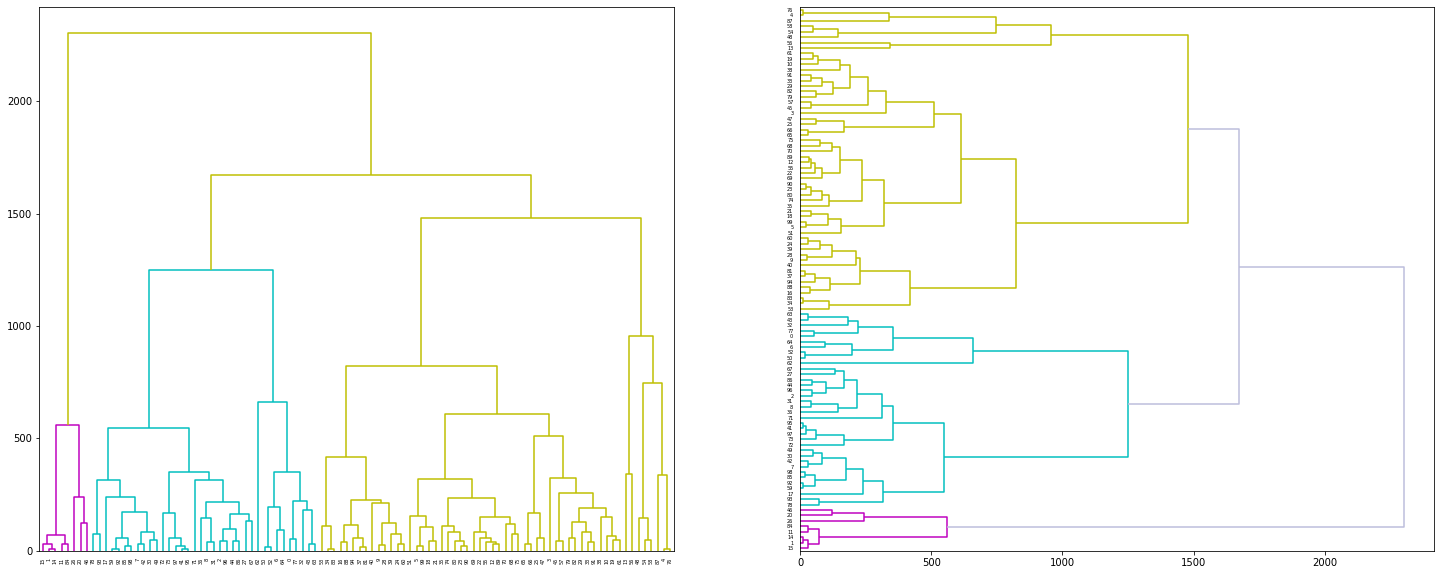

In [141]:
set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(25, 10))
dn1 = dendrogram(our_clusters, ax=axes[0], above_threshold_color='y', 
                 orientation='top')
dn2 = dendrogram(our_clusters, ax=axes[1], above_threshold_color='#bcbddc', 
                 orientation='right')
#plt.savefig('dendrogram', dpi=500, orientation='portrait', papertype=None, 
            format=None, transparent=False, bbox_inches=None, pad_inches=0.1, 
            frameon=None, metadata=None)

set_link_color_palette(None)  # reset to default after use
plt.show()

### Пункт 3
Пусть узлы разбиты на k кластеров.

a. Найти расположение центра масс (центроида) для каждого кластера;

b. Построить дерево кратчайших путей от объекта до центроидов.

c. Для каждого кластера построить дерево кратчайших путей от центроида до
всех вершин кластера.

d. Найти длину построенного дерева и сумму кратчайших расстояний от
объекта до всех заданных узлов.

In [0]:
from scipy.cluster.hierarchy import fcluster

In [0]:
k = 3
clusters = fcluster(our_clusters, k, criterion='maxclust')

In [167]:
clusters_us = {}
clusters_us_id = {}
for i in range(len(clusters)):
    j = clusters[i]
    if j in clusters_us:
        clusters_us[j].append(path_matrix[i])
        clusters_us_id[j].append(i)
    else:
        clusters_us[j] = [path_matrix[i]]
        clusters_us_id[j] = [i]
        
for key, value in clusters_us.items():
    clusters_us[key] = np.array(value)
print(clusters_us)
print(clusters_us_id)

{2: array([[  0., 127.,  96., ..., 129., 130., 210.],
       [ 96., 166.,   0., ...,  67.,  55., 161.],
       [ 84., 125.,  70., ..., 101., 102., 191.],
       ...,
       [ 95., 165.,  17., ...,  62.,  50., 157.],
       [129., 199.,  65., ...,   0.,  71., 151.],
       [131., 201.,  55., ...,  73.,   0., 117.]]), 1: array([[127.,   0., 167., 259., 370., 290., 126., 184., 174., 325., 278.,
         20., 261., 386.,   1.,   7., 316., 217., 297., 280.,  57., 301.,
        268., 270., 327., 304.,  69., 167., 328., 272., 185., 178.,  96.,
        279., 361., 272., 177., 325., 292., 321., 333., 197., 183.,  98.,
        150., 271.,  45., 313., 381., 188., 150., 296., 154., 349., 382.,
        265., 420., 276., 393., 195., 330., 281., 173.,  96., 134., 321.,
        324., 179., 270., 257., 288., 186., 212., 192., 274., 277., 371.,
        138., 212., 270., 270., 323., 268., 360.,   7., 202., 160., 385.,
        320., 263., 268., 281., 194., 213., 327., 196., 166., 198., 199.,
        288.]

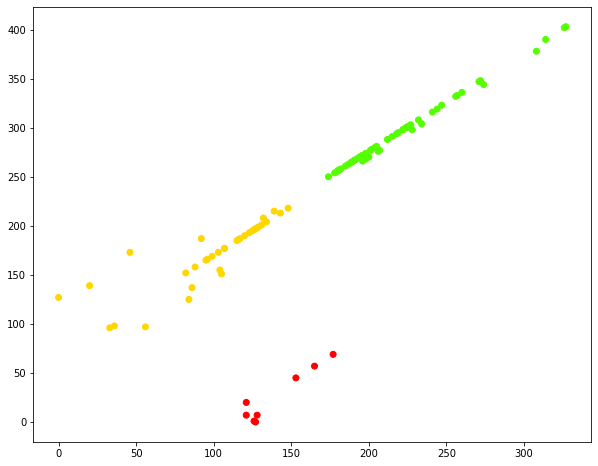

In [144]:
plt.figure(figsize=(10, 8))
plt.scatter(path_matrix[:,0], path_matrix[:,1], c=clusters, cmap='prism')
plt.show()

Ищем центроиды

In [0]:
def centroids(X, Z, clusters,  k, hosp_ind):

    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent %colors
    
    clusters_us = {}
    clusters_us_id = {}
    for i in range(len(clusters)):
        j = clusters[i]
        if j in clusters_us:
            clusters_us[j].append(X[i])
            clusters_us_id[j].append(i)
        else:
            clusters_us[j] = [X[i]]
            clusters_us_id[j] = [i]
            
    for key, value in clusters_us.items():
        clusters_us[key] = np.array(value)
    
    centroids = {}
    centroids_node = {}
    for key, value in clusters_us.items():
        n = len(value)
        x = sum(value[:, 0]) / n
        y = sum(value[:, 1]) / n
        centroids[key] = [x, y]
        
        centroids_node[key] = ox.get_nearest_node(G, (y, x))
        plt.scatter(x, y)
    
    print("Centroids")
    print(centroids)

    plt.savefig('centroids_in_clusters', dpi=500, orientation='portrait', papertype=None, 
            format=None, transparent=False, bbox_inches=None, pad_inches=0.1, 
            frameon=None, metadata=None)   
     
    plt.show()

    return  centroids_node

In [0]:
centroids_node = {}
centroids_node = centroids(path_matrix, our_clusters, clusters, k, index )

Строим дерево кратчайших путей от объекта до центроидов.

In [0]:
# choosen_hospital = {89665061: 7512139535}
hosp_index = 7512139535
routes = []
for centr in centroids_node:
  route = paths[hosp_index][centr]
  routes.append(route)
routes


In [0]:
ox.plot_graph_routes(G, routes, save=False, close=True, file_format='png', 
                     filename='opt_hosp_short_path_tree', dpi=500, fig_height = 30, fig_width = 30, 
                     node_color='#000000', node_size = 1, orig_dest_node_size=5, edge_color='#999999', edge_linewidth=0.7)

Строим для каждого кластера дерево кратчайших путей от центроида до
всех вершин кластера.

In [0]:
routes = []
for key, value in clusters_us_id.items():
    cent_node = centroids_node[key]
    start = nodes_numbers[cent_node]
    p, weight = dijkstra_heap(G, start)
    
    route = nx.shortest_path(G, start, cent_node, weight='length')
    print(value)
    # for i in value:
    #     path = get_path(start, nodes_numbers[apartments_dict[apartments[i]]], p)
    routes.append(route)

fig, ax = ox.plot_graph_routes(G, routes,
                                node_alpha=0, edge_color='lightgray', edge_alpha=1, edge_linewidth=0.8,
                                route_color='#00cc66', route_linewidth=0.8, route_alpha=1,
                                orig_dest_node_size=10, orig_dest_node_color='r', orig_dest_node_alpha=1)

name=str(key)
ox.plot.save_and_show(fig, ax, save=True, show=False, filename=name, file_format='png', close=True, 
                      dpi=500, axis_off=True)
        

Найдем длину построенного дерева и сумму кратчайших расстояний от
объекта до всех заданных узлов.

### Пункт 4
Сравнить найденные в п.1 и 3 величины для k=2, 3, 5

### Интерфейс (?)

In [33]:
print("Выберете действие:")
print("1.Вывести граф Уфы\n 2. Вывести случайные 10 больниц\n 3. Вывести случайные 100 апартаментов\n 4. Запустить алгоритм Дейкстры для всех вершин\n 5. \
Запустить алгоритм Дейкстры для конкретной вершины\n 6. Вывести дерево кратчайших путей из выбранного узла \n 7. Выполнить задание 1.а\n 8. Выполнить \
задание 1.б\n 9. Выполнить задание 1.2\n 10. Выполнить задание 1.3\n 11. Выполнить \
задание 1.4\n 12. Выполнить задание 2.1\n 13. Выполнить задание 2.2\n 14. Выполнить \
задание 2.3\n 15. Выполнить задание 2.4\n  0. Выход")

Выберете действие:
1.Вывести граф Уфы
 2. Вывести случайные 10 больниц
 3. Вывести случайные 100 апартаментов
 4. Запустить алгоритм Дейкстры для всех вершин
 5. Запустить алгоритм Дейкстры для конкретной вершины
 6. Вывести дерево кратчайших путей из выбранного узла 
 7. Выполнить задание 1.а
 8. Выполнить задание 1.б
 9. Выполнить задание 1.2
 10. Выполнить задание 1.3
 11. Выполнить задание 1.4
 12. Выполнить задание 2.1
 13. Выполнить задание 2.2
 14. Выполнить задание 2.3
 15. Выполнить задание 2.4
  0. Выход


In [0]:
option = 1
# while (option < 0 and option > 15):
#   option = int(input())
while(option !=0):
  
  if option == 1:
    fig, ax = ox.plot_graph(G, dpi=500, fig_height=25, fig_width=25, node_color='#000000', node_size=2, edge_color='#999999', edge_linewidth=0.2)
  
  elif option == 2:
    print(hospitals_dict)
  
  elif option == 3:
    print(apartments_dict)
  
  elif option == 4:
    paths = {}
    dists = {}

    for i in range(len(new_nodes)):
        paths[new_nodes[i]], dists[new_nodes[i]], = dijkstra_heap(G, new_nodes[i])

  elif option == 5:
    # l = int(input())
    l = 19
    input_node = new_nodes[l]
    routes = []
    for el in apartments_values:
      index = np.where(new_nodes == el)[0][0]
      route = paths[input_node][new_nodes[index]]
      routes.append(route)
    print(routes)
  
  elif option == 6:
    # l = int(input())
    l = 14
    input_node = new_nodes[l]
    routes = []
    for el in apartments_values:
      index = np.where(new_nodes == el)[0][0]
      route = paths[input_node][new_nodes[index]]
      routes.append(route)
    ox.plot_graph_route(G, input_node, dpi=500, node_color='#000000', node_size=2, edge_color='#999999', edge_linewidth=0.2)

  # elif option == 7:

  # elif option == 8:

  # elif option == 9:

  # elif option == 10:

  # elif option == 11:

  # elif option == 12:

  # elif option == 13:

  # elif option == 14:

  # elif option == 15:

print("GoodBye")
  